# Deskripsi Library

In [1]:
import pandas as pd
import numpy as np

#library visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

#library untuk analisis time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#library yang digunakan untuk forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error




# Memanggil DataSet

In [2]:
df = pd.read_excel('CO2 dataset.xlsx')

# Deskripsi DataSet

In [3]:
df.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


# Transform Data Tahun

In [5]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')


In [6]:
df.set_index(['Year'], inplace=True)

In [7]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [8]:
df.index.min(), df.index.max()

(Timestamp('1800-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

In [9]:
if (df.index.max() - df.index.min() == 214):
    print ('Data is Continous')

In [10]:
df.index.freq = 'YS'

# Analisa Time Series

<Axes: xlabel='Year'>

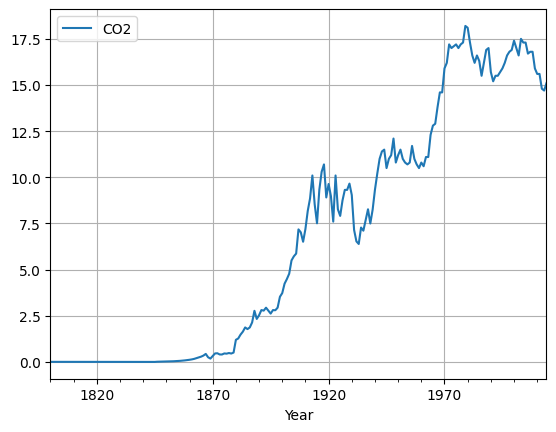

In [11]:
df.plot(grid=True)

In [53]:
train_df = df.loc[:'1991-01-01']
test_df = df.loc['1992-01-01':]


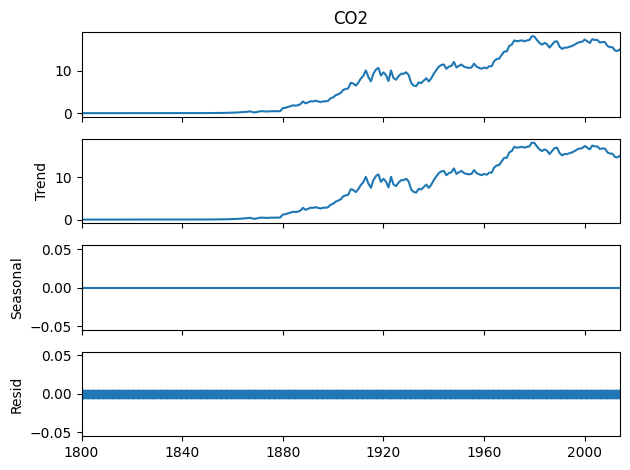

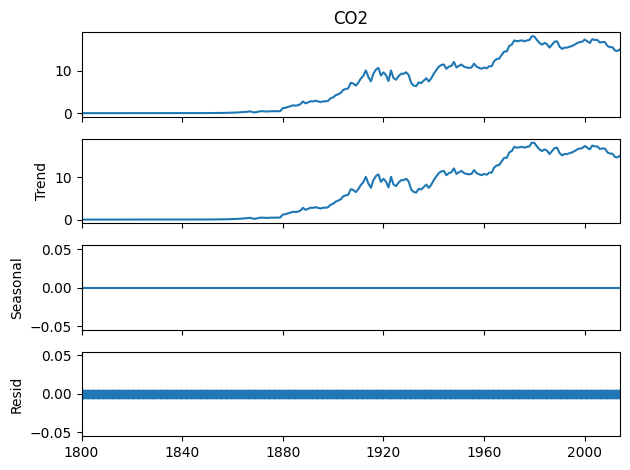

In [70]:
decompose_add = seasonal_decompose(df['CO2'])
decompose_add.plot()

In [72]:
def adf_test(timeseries):
    print('Hasil Test Deckey-Fuller')
    print('---------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','Number Of observation Used'])
    for key, Value in adftest[4].items() :
        adf_output['Critical Value (%s)' %key] = Value
    print (adf_output)

adf_test(df.values)

Hasil Test Deckey-Fuller
---------------------------------
Test Statistic                 -0.378463
p-value                         0.913633
Lags Used                       0.000000
Number Of observation Used    214.000000
Critical Value (1%)            -3.461282
Critical Value (5%)            -2.875143
Critical Value (10%)           -2.574020
dtype: float64


In [73]:
diff_df = df.diff()
diff_df.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [74]:
diff_df.dropna(inplace=True)

<Axes: xlabel='Year'>

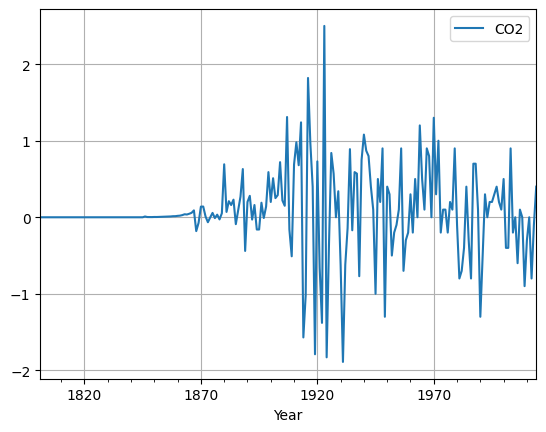

In [75]:
diff_df.plot(grid=True)

In [76]:
adf_test(diff_df)

Hasil Test Deckey-Fuller
---------------------------------
Test Statistic                 -3.780005
p-value                         0.003119
Lags Used                      15.000000
Number Of observation Used    198.000000
Critical Value (1%)            -3.463815
Critical Value (5%)            -2.876251
Critical Value (10%)           -2.574611
dtype: float64


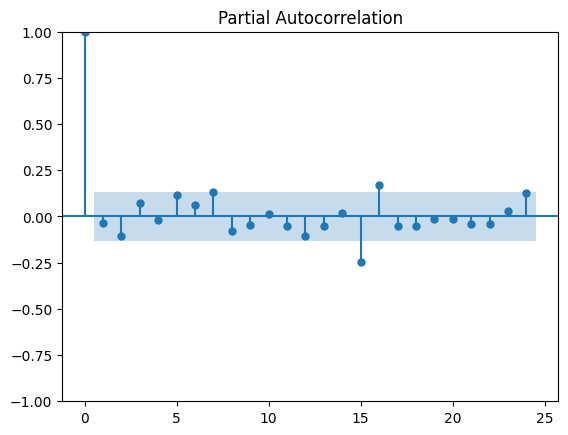

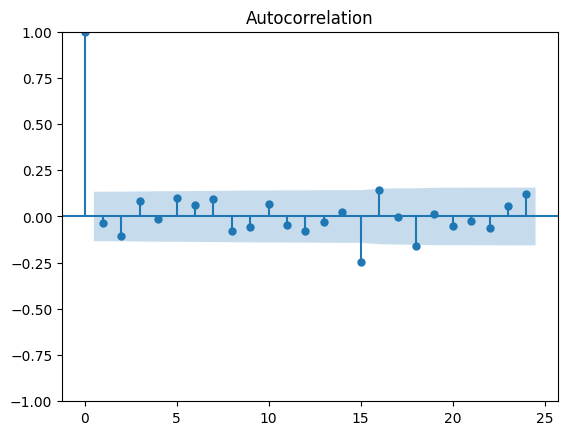

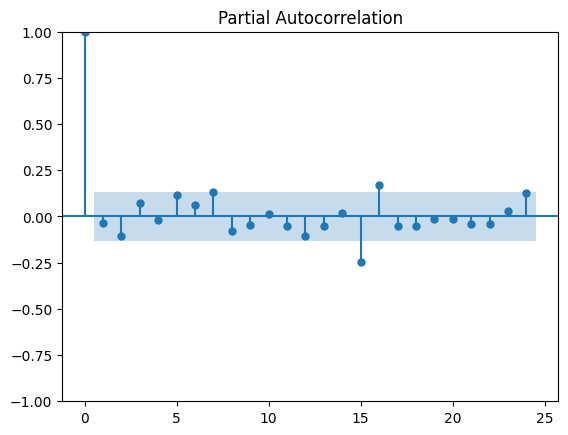

In [77]:
plot_acf(diff_df)
plot_pacf(diff_df)

# ALGORITMA ANALISIS

(Singgle Exponensial Smoothing, Double Exponensial Smoothing, ARIMA )

1. Test Dengan Single Exponensial Smoothing

In [78]:
singgle_exp = SimpleExpSmoothing(train_df).fit()
singgle_exp_train_pred = singgle_exp.fittedvalues
singgle_exp_test_pred = singgle_exp.forecast(23)

<Axes: xlabel='Year'>

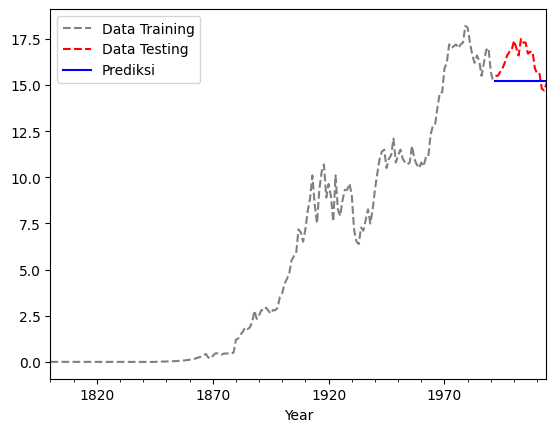

In [79]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='Data Training')
test_df['CO2'].plot(style='--', color='r', legend=True, label='Data Testing')
singgle_exp_test_pred.plot(color='b', legend=True, label='Prediksi')


In [98]:
print('Train RMSE :',mean_squared_error(train_df, singgle_exp_train_pred)**0.5)
print('Train RMSE :',mean_squared_error(test_df, singgle_exp_test_pred)**0.5)
print('Train MAPE :',mean_absolute_percentage_error(train_df, singgle_exp_train_pred))
print('Test MAPE  :',mean_absolute_percentage_error(test_df, singgle_exp_test_pred))


Train RMSE : 0.564692002680021
Train RMSE : 1.3429113022690744
Train MAPE : 0.08470457297144991
Test MAPE  : 0.06861466412071275


2. Test Dengan Double Exponensial Smoothing

In [99]:
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(23)

<Axes: xlabel='Year'>

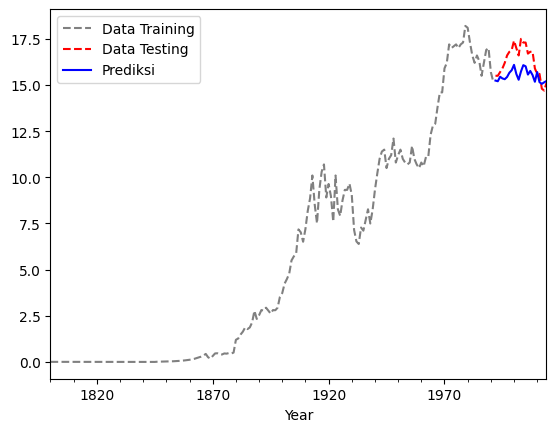

In [119]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='Data Training')
test_df['CO2'].plot(style='--', color='r', legend=True, label='Data Testing')
double_exp_test_pred.plot(color='b', legend=True, label='Prediksi')


In [118]:
print('Train RMSE :',mean_squared_error(train_df, double_exp_train_pred)**0.5)
print('Train RMSE :',mean_squared_error(test_df, double_exp_test_pred)**0.5)
print('Train MAPE :',mean_absolute_percentage_error(train_df, double_exp_train_pred))
print('Test MAPE  :',mean_absolute_percentage_error(test_df, double_exp_test_pred))

Train RMSE : 0.55762633115863
Train RMSE : 0.9739218311395732
Train MAPE : 14.722686183369868
Test MAPE  : 0.05078156866533681


3. Test Dengan Algoritma ARIMA

In [114]:
ar = ARIMA(train_df, order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(23)

c:\Users\firdos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Year'>

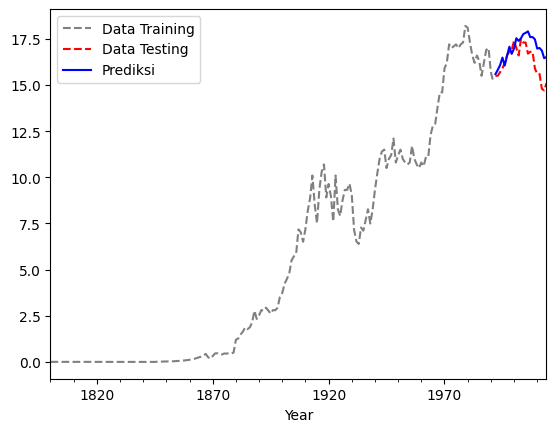

In [115]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='Data Training')
test_df['CO2'].plot(style='--', color='r', legend=True, label='Data Testing')
ar_test_pred.plot(color='b', legend=True, label='Prediksi')

In [116]:
print('Train RMSE :',mean_squared_error(train_df, ar_train_pred)**0.5)
print('Train RMSE :',mean_squared_error(test_df, ar_test_pred)**0.5)

print('Train MAPE :',mean_absolute_percentage_error(train_df, ar_train_pred))
print('Test MAPE  :',mean_absolute_percentage_error(test_df, ar_test_pred))

Train RMSE : 0.46799037863156306
Train RMSE : 0.9490440336439826
Train MAPE : 0.0815886992948432
Test MAPE  : 0.04714917900331774


# Perbandingan Masing-Masing Algoritma

In [121]:
comparision_df = pd.DataFrame(data=[
    ['Simple Exp Smoothing', 1.3429, 0.0686],
    ['Double Exp Smoothing', 0.5352, 0.0260],
    ['ARIMA', 0.9549, 0.0472]
    ],
    columns=['Model', 'RMSE', 'MAPE'])
comparision_df.set_index('Model', inplace=True)

In [122]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
Double Exp Smoothing,0.5352,0.0260
ARIMA,0.9549,0.0472
Simple Exp Smoothing,1.3429,0.0686


In [125]:
double_exp = ExponentialSmoothing(df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_pred = double_exp.forecast(20)

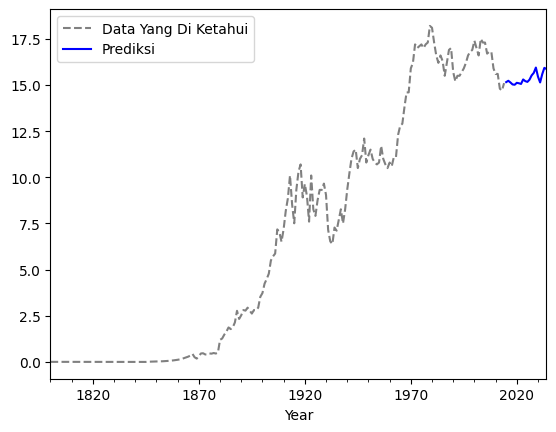

In [128]:
df['CO2'].plot(style='--', color='gray', legend=True, label='Data Yang Di Ketahui')
double_exp_pred.plot(color='b', legend=True, label='Prediksi')
plt.show()

In [126]:
import pickle

In [127]:
pickle.dump(double_exp, open('prediksi_co2.sav','wb'))